In [1]:
import numpy as np
from openvino.inference_engine import IENetwork,IECore
import cv2
from matplotlib import pyplot as plt
import math 

#initialize models
import face_detection
face_detection_model = 'models/face-detection-adas-binary-0001/FP32-INT1/face-detection-adas-binary-0001'
fd = face_detection.face_detection(face_detection_model)
fd.load_model()
fd.check_model()
fd.get_input_name()


import landmark_detection
landmark_detection_model = 'models/landmarks-regression-retail-0009/FP16/landmarks-regression-retail-0009'
ld = landmark_detection.landmark_detection(landmark_detection_model)
ld.load_model()
ld.check_model()
ld.get_input_name()


import head_pose_estimation
head_pose_estimation_model = 'models/head-pose-estimation-adas-0001/FP16/head-pose-estimation-adas-0001'
hd = head_pose_estimation.head_pose_estimation(head_pose_estimation_model)
hd.load_model()
hd.check_model()
hd.get_input_name()

import gaze_estimation
gaze_estimation_model = 'models/gaze-estimation-adas-0002/FP16/gaze-estimation-adas-0002'
ge = gaze_estimation.gaze_estimation(gaze_estimation_model)
ge.load_model()
ge.check_model()
ge.get_input_name()

Successfully loaded the network
All layers supported
Successfully loaded the network
All layers supported
Successfully loaded the network
All layers supported
Successfully loaded the network
All layers supported


In [42]:

input_image = ['bin/img1.png','bin/img4.jpg']
cropped_image = None

#Handle face detection

for image_id,input_image in enumerate(input_image):
    print(image_id+1,input_image)
    input_img = fd.pre_process_input(input_image)
    result = fd.predict(input_img)
    output_image = fd.preprocess_output(result)
    cropped_image = fd.cropped_image()
    print("Cropped {} person Successfully".format(len(cropped_image)))

1 bin/img1.png
Cropped 5 person Successfully
2 bin/img4.jpg
Cropped 4 person Successfully


In [43]:
#Handle landmark detection
crop_percentage = 0.5
left_eye =[]
right_eye = []
x_coord = []
y_coord = []
for image_id,input_img in enumerate(cropped_image):
    pre_processed_img = ld.pre_process_input(input_img)
    result = ld.predict(pre_processed_img)
    output_image,x_axis,y_axis = ld.preprocess_output(result)
    left_eye_crop = ld.crop_left_eye(crop_percentage)
    left_eye.append(left_eye_crop)
    right_eye_crop = ld.crop_right_eye(crop_percentage)
    right_eye.append(right_eye_crop)
    y_coord.append(y_axis)
    x_coord.append(x_axis)


In [44]:
#Handle head pose

headpose=[]
for image_id,input_img in enumerate(cropped_image):
    pre_processed_img = hd.pre_process_input(input_img)
    result = hd.predict(pre_processed_img)
    output = hd.preprocess_output(result)
    headpose.append(output)
    
headpose

[array([[ 16.989155, -16.42661 ,   9.898043]], dtype=float32),
 array([[-12.601593 , -33.601944 ,  -2.3125439]], dtype=float32),
 array([[-25.263527, -28.041058,  -9.827201]], dtype=float32),
 array([[-11.9453125, -18.220198 ,  14.118452 ]], dtype=float32)]

In [45]:
# Handle gaze model

left_eye_input = []
right_eye_input = []
ge_results=[]

for value in left_eye:
    res = ge.pre_process_input(value)
    left_eye_input.append(res)
    
for value in right_eye:
    res = ge.pre_process_input(value)
    right_eye_input.append(res)


for idx in range(len(left_eye_input)):
    result_ge = ge.predict(headpose[idx],left_eye_input[idx],right_eye_input[idx])
    process_output = ge.preprocess_output(result_ge)
    ge_results.append(process_output)
    
ge_results

[array([[-0.03486424,  0.32357246, -0.8987567 ]], dtype=float32),
 array([[-0.20174135,  0.35231668, -0.89900166]], dtype=float32),
 array([[-0.32831433,  0.41646254, -0.78113896]], dtype=float32),
 array([[-0.26417422,  0.02325774, -0.9431226 ]], dtype=float32)]

In [46]:
#testing single image
# Handle gaze model

left_eye_input = []
right_eye_input = []
ge_results=[]

for value in left_eye:
    res = ge.pre_process_input(value)
    left_eye_input.append(res)
    
for value in right_eye:
    res = ge.pre_process_input(value)
    right_eye_input.append(res)



0 {'gaze_vector': array([[-0.03486424,  0.32357246, -0.8987567 ]], dtype=float32)}


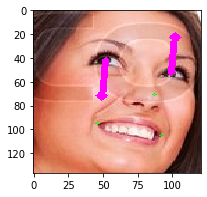

1 {'gaze_vector': array([[-0.20174135,  0.35231668, -0.89900166]], dtype=float32)}


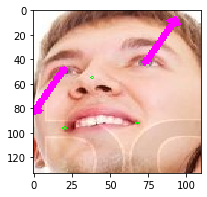

2 {'gaze_vector': array([[-0.32831433,  0.41646254, -0.78113896]], dtype=float32)}


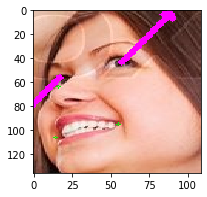

3 {'gaze_vector': array([[-0.26417422,  0.02325774, -0.9431226 ]], dtype=float32)}


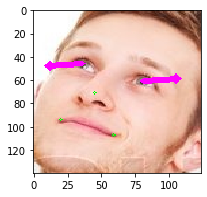

In [47]:
#idx=0
gaze_vector = []
for idx in range(len(left_eye_input)):
    result_ge = ge.predict(headpose[idx],left_eye_input[idx],right_eye_input[idx])
    print(idx,result_ge)
    gaze_vec = result_ge['gaze_vector'].tolist()[0]
    gaze_vector.append(gaze_vec)
    image_copy = cropped_image[idx]
    image = cv2.arrowedLine(image_copy, (x_coord[idx][0],y_coord[idx][0]),
                            (x_coord[idx][0] + int(gaze_vector[idx][0]*100),
                             y_coord[idx][0]+int(gaze_vector[idx][1]*100)),
                            (255,0,255),3)
    image = cv2.arrowedLine(image_copy, 
                    (x_coord[idx][1],y_coord[idx][1]), 
                    (x_coord[idx][1] - int(gaze_vector[idx][0]*100), 
                     y_coord[idx][1]-int(gaze_vector[idx][1]*100)),
                    (255,0,255),3)
    ld.plot_image(image)
    

In [39]:
#gaze vector processing output


gaze_vector = result_ge['gaze_vector'].tolist()[0]
rollValue = headpose[idx][0][2]

cosValue = math.cos(rollValue * math.pi / 180.0)
sinValue = math.sin(rollValue * math.pi / 180.0)

newx = gaze_vector[0] * cosValue + gaze_vector[1] * sinValue
newy = -gaze_vector[0] *  sinValue+ gaze_vector[1] * cosValue


(newx,newy), gaze_vector

((0.11908751383054772, 0.43520515941588417),
 [0.08088379353284836, 0.44389545917510986, -0.7408611178398132])

In [42]:
x_coord,y_coord

([53, 82, 78, 52, 76], [54, 54, 76, 104, 104])

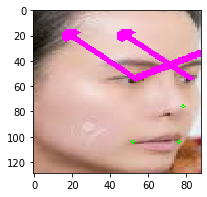

In [49]:
eye_id = 0
image = cv2.arrowedLine(cropped_image[idx], 
                        (x_coord[eye_id],y_coord[eye_id]), 
                        (x_coord[eye_id] + int(gaze_vector[0]*100), 
                         y_coord[eye_id]+int(gaze_vector[1]*100)),
                        (255,0,255),3) 
ld.plot_image(image)

In [48]:

x_coord[eye_id] + int(gaze_vector[0]*100), y_coord[eye_id]+int(gaze_vector[1]*100)

(115, 18)

In [ ]:
x_coord[1] - int(gaze_vector[1]*100), y_coord[2]+int(gaze_vector[1]*100)

In [56]:
gaze_vector[0][1]*100

-36.82376444339752

In [ ]:
x, y, w = int(gaze_vector[0]*12), int(gaze_vector[1]*12), 160
le =cv2.line(left_eye.copy(), (x-w, y-w), (x+w, y+w), (255,0,255), 2)
cv2.line(le, (x-w, y+w), (x+w, y-w), (255,0,255), 2)
re = cv2.line(right_eye.copy(), (x-w, y-w), (x+w, y+w), (255,0,255), 2)
cv2.line(re, (x-w, y+w), (x+w, y-w), (255,0,255), 2)
croppedFace[eye_coords[0][1]:eye_coords[0][3],eye_coords[0][0]:eye_coords[0][2]] = le
croppedFace[eye_coords[1][1]:eye_coords[1][3],eye_coords[1][0]:eye_coords[1][2]] = re


In [6]:
rvec = np.array([0, 0, 0], np.float)
# translation vector
tvec = np.array([0, 0, 0], np.float)
# camera matrix
camera_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], np.float)

result, _ = cv2.projectPoints((0.27571675,  0.17352335, -0.65603495), rvec, tvec, camera_matrix, None)
result

array([[[-0.42027753, -0.26450321]]])

In [7]:
cv2.projectPoints((0.27571675,  0.17352335, -0.65603495), rvec, tvec, camera_matrix, None)


(array([[[-0.42027753, -0.26450321]]]),
 array([[-0.11116476,  1.1766332 ,  0.26450321, -1.52430903,  0.        ,
         -0.64063284, -0.42027753,  0.        ,  1.        ,  0.        ,
         -0.1036384 , -0.02555673,  0.22232951,  0.59986156, -0.00630217],
        [-1.06996195,  0.11116476, -0.42027753,  0.        , -1.52430903,
         -0.40318463,  0.        , -0.26450321,  0.        ,  1.        ,
         -0.06522521, -0.01608422,  0.38651905,  0.22232951, -0.00396629]]))

In [12]:
result = result[0,0]
cropped_image[0]
left_eye =[]
right_eye = []

In [14]:
left_eye[0][0][0]

array([60, 31, 35], dtype=uint8)

In [ ]:
res = (int(result[0] * 100), int(result[1] * 100))  #2.5, 2.9
e1 = (cropped_image[0][0][0] + model_landmarks_output[0][0],
      cropped_image[0][0][1] + model_landmarks_output[0][1])
e2 = (cropped_image[0][0][0] + model_landmarks_output[1][0],
      cropped_image[0][0][1] + model_landmarks_output[1][1])

cv2.arrowedLine(image, e1, (e1[0] - res[0], e1[1] + res[1]), (0, 0, 255), 5)
cv2.arrowedLine(image, e2, (e2[0] - res[0], e2[1] + res[1]), (0, 0, 255), 5)

In [ ]:
def display_intermediate(image, model_face_output, model_landmarks_output, result):
    # face bounding box
    image = cv2.rectangle(image, model_face_output[0], model_face_output[1], (255, 0, 0), 2)

    # gaze vector projection
    res = (int(result[0] * 100), int(result[1] * 100))
    e1 = (model_face_output[0][0] + model_landmarks_output[0][0],
          model_face_output[0][1] + model_landmarks_output[0][1])
    e2 = (model_face_output[0][0] + model_landmarks_output[1][0],
          model_face_output[0][1] + model_landmarks_output[1][1])

    cv2.arrowedLine(image, e1, (e1[0] - res[0], e1[1] + res[1]), (0, 0, 255), 5)
    cv2.arrowedLine(image, e2, (e2[0] - res[0], e2[1] + res[1]), (0, 0, 255), 5)
    return image

In [ ]:
def process_single_frame(image, display_intermediate_output):
    model_face_output = model_face.predict(image)
    if model_face_output[2] is None:
        return 'No face detected', image

    model_landmarks_output = model_landmarks.predict(model_face_output[2])
    model_head_pose_output = model_hpose.predict(model_face_output[2])
    gaze_estimation_output = model_gaze_estimation.predict(
        ((model_landmarks_output[2], model_landmarks_output[3]), model_head_pose_output))

    # rotation vector
    rvec = np.array([0, 0, 0], np.float)
    # translation vector
    tvec = np.array([0, 0, 0], np.float)
    # camera matrix
    camera_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], np.float)

    result, _ = cv2.projectPoints(gaze_estimation_output, rvec, tvec, camera_matrix, None)
    result = result[0][0]

    if display_intermediate_output:
        image = display_intermediate(image, model_face_output, model_landmarks_output, result)

    print('.', end='', flush=True)
    return result, image



def display_intermediate(image, model_face_output, model_landmarks_output, result):
    # face bounding box
    image = cv2.rectangle(image, model_face_output[0], model_face_output[1], (255, 0, 0), 2)

    # gaze vector projection
    res = (int(result[0] * 100), int(result[1] * 100))
    e1 = (model_face_output[0][0] + model_landmarks_output[0][0],
          model_face_output[0][1] + model_landmarks_output[0][1])
    e2 = (model_face_output[0][0] + model_landmarks_output[1][0],
          model_face_output[0][1] + model_landmarks_output[1][1])

    cv2.arrowedLine(image, e1, (e1[0] - res[0], e1[1] + res[1]), (0, 0, 255), 5)
    cv2.arrowedLine(image, e2, (e2[0] - res[0], e2[1] + res[1]), (0, 0, 255), 5)
    return image